# Week6 Statistical Inference with Python

In week6, we've covered:
* **Variance**:  
    * Measuring Uncertainty  
    * Prior and Posterior Distributions  
    * Credible Intervals  
* **Inference**:  
    * Hypothesis Testing  
    * False Discovery Rate  

The best way to consolidate the knowledge in your mind is by practicing.<br>Please complete the part marked with <span style="color:green">**# TODO**</span>.

[Google](www.google.com) and [Python Documentation](https://docs.python.org/3/contents.html) are your good friends if you have any python questions.

Upload **Week6_Statistical_Inference_With_Python_Homework.ipynb** notebook to your Google Drive and open it with Google Colab

## Inference  

Recall that last week, we were introduced to statistical inference using batting averages from baseball as a running example. We used the binomial distribution to model the likelihood that a player would get a hit during an at bat, given historical data. We used the beta distribution to estimate batting averages and measure our uncertainty.  

This covered the first two articles of this series titled "The beta distribution" and "Emperical Bayes estimation": http://varianceexplained.org/r/simulation-bayes-baseball/  

Let's continue the discussion of variance, and discuss how to use variance to come up with a range for our estimates of batting averages. By the end of this exercise, you should feel comfortable giving a probability that an estimate lies in an interval. Read about credible intervals in the third article of the series: http://varianceexplained.org/r/credible_intervals_baseball/  

### Exercises  

1. Run the codeblock below to reproduce the dataset from last week. Print out `alpha0` and `beta0`.  

In [21]:
import pandas as pd

# read the dataset
batting_url = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Batting.csv'
pitching_url = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/Pitching.csv'
people_url = 'https://raw.githubusercontent.com/chadwickbureau/baseballdatabank/master/core/People.csv'

batting = pd.read_csv(batting_url)
pitching = pd.read_csv(pitching_url)
master = pd.read_csv(people_url)

# recreate career dataframe
pitchers = pitching['playerID'].tolist()
batting = batting[batting['AB'] > 0]
batting = batting[~batting['playerID'].isin(pitchers)] #filtered out pitchers
batting_sum =batting.groupby(['playerID']).agg({'H':'sum','AB':'sum'}) # get total hits and at bats for each player
batting_sum['Avg'] = batting_sum.loc[:,'H'] / batting_sum.loc[:,'AB'] #calculate the avg batting rate
career = pd.merge(batting_sum, master, how='inner', on='playerID')[["playerID","nameFirst", "nameLast", "H", "AB", "Avg"]]
career= career[career["AB"]>=500]
career.head()

# helper function to estimate priors for alpha and beta
def moments(mu, sigma2):
    alpha = mu**2 * ((1 - mu) / sigma2 - 1 / mu)
    beta = alpha * (1 / mu - 1)
    return (alpha, beta)

# get priors for alpha and beta
empirical_mean = career['Avg'].to_numpy().mean()
empirical_variance = career['Avg'].to_numpy().var()
alpha0, beta0 = moments(empirical_mean, empirical_variance)

# use priors to update estimate of batting average for each player
career['eb'] = ((career.loc[:,'H'] + alpha0) / (career.loc[:,'AB'] + alpha0 + beta0))

# concatenate first and last name
career['name'] = career.loc[:, 'nameFirst'] + ' ' + career.loc[:, 'nameLast']
career.sort_values('eb', ascending=False).loc[:,["playerID", 'name', 'H', 'AB', 'Avg', 'eb']].head(5)

,playerID,name,H,AB,Avg,eb
4154,hornsro01,Rogers Hornsby,2930,8173,0.358497,0.354891
4345,jacksjo01,Shoeless Joe Jackson,1772,4981,0.355752,0.350125
2227,delahed01,Ed Delahanty,2597,7510,0.345806,0.342387
3659,hamilbi01,Billy Hamilton,2164,6283,0.344421,0.340430
3860,heilmha01,Harry Heilmann,2660,7787,0.341595,0.338452


2. Recall `alpha0` and `beta0` represent prior belief for the "average player" as determined by the entire data set. Use your knowledge from last week to generate an array of `1000` samples from a beta distribution with parameters `alpha0` and `beta0`.
    
 2a. Calculate the sample mean and compare it to the ratio $\frac{\alpha_0}{\alpha_0 + \beta_0}$

In [22]:
# TODO
import numpy as np

batting_avg_new = np.random.beta(alpha0, beta0, 1000)
print("mean", np.mean(batting_avg_new))

p = alpha0/ (alpha0 + beta0)
print(alpha0, beta0)
print("ratio", p)

mean 0.25704704230428227
78.49871612173963 225.74873615173013
ratio 0.2580094444017952


  2b. Calculate the 0.10 and 0.90 quantlies of the sample.  

In [23]:
# TODO
quantile_10 = np.percentile(batting_avg_new, 10)
quantile_90 = np.percentile(batting_avg_new, 90)

print("0.10 Quantile:", quantile_10)
print("0.90 Quantile:", quantile_90)

0.10 Quantile: 0.22592692754914329
0.90 Quantile: 0.2893489646351009


3. Find two players in the `career` dataframe that have a similar `Avg` but very different at bats (`AB`).
  
  3a. Create a two-row dataframe that includes only these two players, and display their `name`, `H`, `AB`, `Avg`, and estimated avg (`eb`).

In [24]:
# TODO
sorted_career = career.sort_values('Avg', ascending=False).loc[:,['name', 'H', 'AB', 'Avg', 'eb']]

# Iterate through the dataframe and find players with similar Avg but different AB
for i in range(len(sorted_career) - 1):
    curr_player = sorted_career.iloc[i]
    next_player = sorted_career.iloc[i+1]
    if abs(curr_player['Avg'] - next_player['Avg']) < 0.0001 and abs(curr_player['AB'] - next_player['AB']) > 5000:
        similar_players = pd.DataFrame({'name':[curr_player['name'], next_player['name']],
                                        'H': [curr_player['H'], next_player['H']],
                                        'AB': [curr_player['AB'], next_player['AB']],
                                        'AVG': [curr_player['Avg'], next_player['Avg']],
                                        'eb': [curr_player['eb'], next_player['eb']]})
        break

print(similar_players, type(similar_players))



               name     H    AB       AVG        eb
0      Bill Everitt   902  2842  0.317382  0.311641
1  Roberto Clemente  3000  9454  0.317326  0.315477 <class 'pandas.core.frame.DataFrame'>


3b. Calculate the *posterior* values for $\alpha$ and $\beta$ for the two players in your subset.

(This Stack Overflow answer details the update process for $\alpha$ and $\beta$: https://stats.stackexchange.com/a/47782)

In [25]:
# TODO


similar_players["new_alpha"] = similar_players["H"].apply(lambda x : x + alpha0)
similar_players["new_beta"] = similar_players["AB"] - similar_players["H"] + beta0
similar_players

,name,H,AB,AVG,eb,new_alpha,new_beta
0,Bill Everitt,902,2842,0.317382,0.311641,980.498716,2165.748736
1,Roberto Clemente,3000,9454,0.317326,0.315477,3078.498716,6679.748736


  3c. Though the `Avg` and the priors (`alpha0`, `beta0`) are similar for your two players, their estimated variance should be very different (due to the difference in at bats). Make an argument (no proof required): Which of your two players will have a lower 0.10 quantile for the posterior distribution of their estimated batting average (`eb`)? Explain your reasoning in a sentence or two.

TODO: Make your argument:

More data will align closer to the average; law of large numbers

3d. Use your posterior alphas and betas to generate a sample of `1000` estimated batting averages for each of your two players. Calculate the 0.10 and 0.90 quantile for each sample distribution. Compare the outcome to your prediction in 3c. Reconcile any differences.

Bill Everitt 0.31143242569667173 0.3011874607703232 0.3217026499428933
Roberto Clemente 0.3153588452389615 0.3093611539172454 0.32143186237899174


<ipython-input-26-2638450e5169>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=batting_avg_0, label= similar_players["name"].values[0])
<ipython-input-26-2638450e5169>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=batting_avg_1, label=similar_players["name"].values[1])


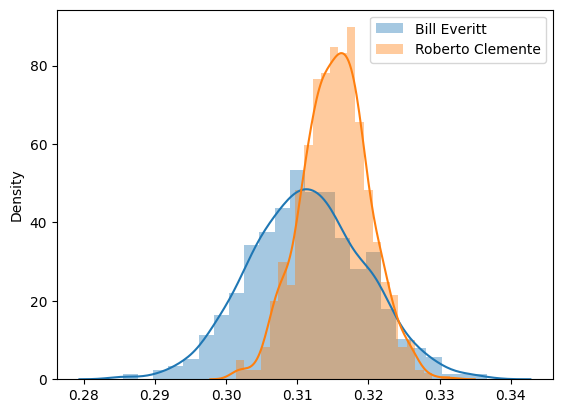

In [26]:
batting_avg_0 = np.random.beta(similar_players["new_alpha"].values[0], similar_players["new_beta"].values[0], 1000)
batting_avg_1 = np.random.beta(similar_players["new_alpha"].values[1], similar_players["new_beta"].values[1], 1000)

mean_Bill_Everitt	= np.mean(batting_avg_0)
quantile_10_Bill_Everitt= np.percentile(batting_avg_0, 10)
quantile_90_Bill_Everitt= np.percentile(batting_avg_0, 90)

mean_Roberto = np.mean(batting_avg_1)
quantile_10_Roberto = np.percentile(batting_avg_1, 10)
quantile_90_Roberto = np.percentile(batting_avg_1, 90)

print(similar_players["name"].values[0], mean_Bill_Everitt, quantile_10_Bill_Everitt, quantile_90_Bill_Everitt)
print(similar_players["name"].values[1], mean_Roberto, quantile_10_Roberto, quantile_90_Roberto)

import seaborn as sns
from matplotlib import pyplot as plt
sns.distplot(a=batting_avg_0, label= similar_players["name"].values[0])
sns.distplot(a=batting_avg_1, label=similar_players["name"].values[1])
plt.legend()
plt.show()



4. Finally, let's compare confidence and credible intervals.

  4a. For each of your two players, use their `H` and `AB` to calculate the 95% binomial proportion confidence interval.
  
  (The wikipedia entry will be helpful: https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval. Note that for a 95% confidence interval, the *z* score is 1.96.)

([<matplotlib.axis.XTick at 0x7bda4e9b0580>,
 [Text(1, 0, '1'), Text(2, 0, '2')])

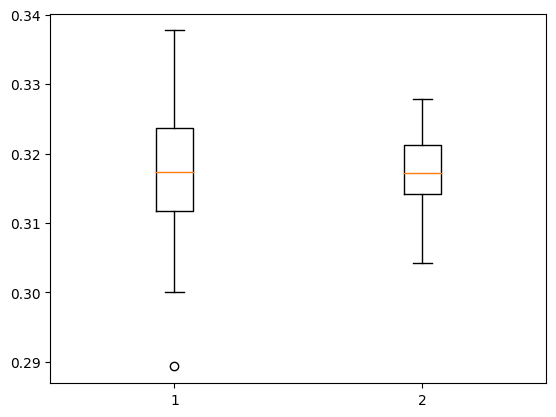

In [42]:
# TODO

import math

similar_players["p"] = similar_players["H"]/similar_players["AB"]
z_score = 1.96

similar_players["Standard_Error"] = similar_players.apply(lambda similar_players: math.sqrt((similar_players["p"] * (1 - similar_players["p"])) / similar_players["AB"]), axis=1)


similar_players["lower_limit"] = similar_players["p"] - z_score * similar_players["Standard_Error"]
similar_players["upper_limit"] = similar_players["p"] + z_score * similar_players["Standard_Error"]

similar_players

#add boxplot here to show bounds and line in the middle to show ranges between the two. or a scatter plot that would cret

import matplotlib.pyplot as plt
Player_Bill = np.random.normal(similar_players["p"].values[0], similar_players["Standard_Error"].values[0], 100)
Player_Roberto = np.random.normal(similar_players["p"].values[1], similar_players["Standard_Error"].values[1], 100)

plt.boxplot([Player_Bill, Player_Roberto])
plt.xticks([1, 2])




4b. Calculate the 95% credible interval using `alpha` and `beta`. Compare the difference between the confidence interval and the credible interval.

(Here is another resource for understanding confidence vs credible intervals: https://towardsdatascience.com/do-you-know-credible-interval-e5b833adf399)

In [28]:
# TODO
import scipy.stats as stats

# Calculate the 95% credible interval for each player
player1_credible_interval = stats.beta.interval(0.95, similar_players["new_alpha"].values[0], similar_players["new_beta"].values[0])
player2_credible_interval = stats.beta.interval(0.95, similar_players["new_alpha"].values[1], similar_players["new_beta"].values[1])

print("Player 1 95% Credible Interval:", player1_credible_interval)
print("Player 2 95% Credible Interval:", player2_credible_interval)



Player 1 95% Credible Interval: (0.295574030526054, 0.327934159712756)
Player 2 95% Credible Interval: (0.3062929519451471, 0.3247318863610212)


## Hypothesis Testing

Now that you have a handle on credible intervals, you are ready to use those intervals to test hypotheses.

Read the fourth article to begin to understand how credible intervals can be useful to make decisions: http://varianceexplained.org/r/bayesian_fdr_baseball/

### Exercises  

5. Let's aggregate Hank Aaron's seasons to get his total career at bats.

In [29]:
h_aaron = career[career['playerID'] == 'aaronha01']
h_aaron.head(5)

,playerID,nameFirst,nameLast,H,AB,Avg,eb,name
0,aaronha01,Hank,Aaron,3771,12364,0.304998,0.30387,Hank Aaron


5a. Calculate Hank Aaron's total Hits (`H`) and At Bats (`AB`)

In [31]:
# TODO
h_aaron["new_alpha"] = h_aaron["H"] + alpha0
h_aaron["new_beta"] = h_aaron["AB"] - h_aaron["H"] + beta0
h_aaron

<ipython-input-31-25a355c5c36b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_aaron["new_alpha"] = h_aaron["H"] + alpha0
<ipython-input-31-25a355c5c36b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_aaron["new_beta"] = h_aaron["AB"] - h_aaron["H"] + beta0


,playerID,nameFirst,nameLast,H,AB,Avg,eb,name,new_alpha,new_beta
0,aaronha01,Hank,Aaron,3771,12364,0.304998,0.30387,Hank Aaron,3849.498716,8818.748736



5b. Use random sampling to estimate the probability that Hank Aaron's career batting average is below 0.300.

In [35]:
# TODO
random_sample = np.random.beta(h_aaron["new_alpha"], h_aaron["new_beta"], 1000)



proportion_below_30 = np.mean(random_sample < 0.300)
print(proportion_below_30)

0.173


5c. Use random sampling to estimate the probability that the *average* player has a career batting average below 0.300

In [36]:
# TODO

random_sample = np.random.beta(alpha0, beta0, 1000)

proportion_below_30 = np.mean(random_sample < 0.300)
print(proportion_below_30)

0.948


5d. How would you use the estimates from 4b and 4c to describe how good a hitter Hank Aaron was?

6. Find two rows of the `career` dataframe that have the same `eb` estimate (to the third decimal place). Compare the posterior error probability that each of these players has a batting average below 0.300. Reconcile any differences.

In [ ]:
for i in range(len(sorted_career) - 1):
    curr_player = sorted_career.iloc[i]
    next_player = sorted_career.iloc[i+1]
    if abs(curr_player['eb'] - next_player['eb']) < 0.001 and abs(curr_player['AB'] - next_player['AB']) > 5000:
        eb_comp = pd.DataFrame({'name':[curr_player['name'], next_player['name']],
                                        'H': [curr_player['H'], next_player['H']],
                                        'AB': [curr_player['AB'], next_player['AB']],
                                        'AVG': [curr_player['Avg'], next_player['Avg']],
                                        'eb': [curr_player['eb'], next_player['eb']]})
        break

eb_comp["new_alpha"] = eb_comp["H"] + alpha0
eb_comp["new_beta"] = eb_comp["AB"] - eb_comp["H"] + beta0

import scipy.stats as stats
eb_comp["pep"] = stats.beta.cdf(.3, eb_comp["new_alpha"], eb_comp["new_beta"])
eb_comp

## Submission

Download completed **Week6_Statistical_Inference_With_Python_Homework.ipynb** from Google Colab and commit to your personal Github repo you shared with the faculty.